# Multilayer Perceptron from MNIST raw data using PyTorch

This notebook will guide you through the use of the `pytroch` framework to train a multilayer perceptron for handwritten digits classification. You are going to use the `mnist` dataset from LeCun et al. 1998

We assume you are using `torch` and `torchvision` packages, if not please install them with `pip`.

## Importing packages

In [1]:
# First, import pytorch, get its version and check available device.

import torch
print(f'Your torch version is {torch.__version__}')
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device

Your torch version is 2.6.0


device(type='mps')

In [2]:
##############################################
#  COMPLETE CODE BELOW WHERE YOU SEE # ...   #
##############################################

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # for evaluating results
from tqdm import tqdm # for progress bars

# ... import here the different pytorch libraries you need
from torchvision import datasets
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader
import torch.nn as nn


%matplotlib inline

## Downloading MNIST dataset
Pytorch provides a set of pre-loaded datasets including MNIST. We will convert our MNIST images into tensors when loading them. There are lots of other transformations that you can do using torchvision.transforms like Reshaping, normalizing, etc. on your images but we won't need that since MNIST is a very primitive dataset.


In [ ]:
Transform = ToTensor() # let us convert mnist data to tensors
train_data = datasets.MNIST(
    root = '../data/', # path to save mnist data 
    train = True,                         
    transform = Transform, 
    download = True,            
)

test_data = datasets.MNIST(
    root = '../data/', 
    train = False, 
    transform = Transform,
    download = True
)

## Printing train_data and test_data

In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

## Visualization of MNIST dataset


Size: torch.Size([1, 28, 28]) Label: 5


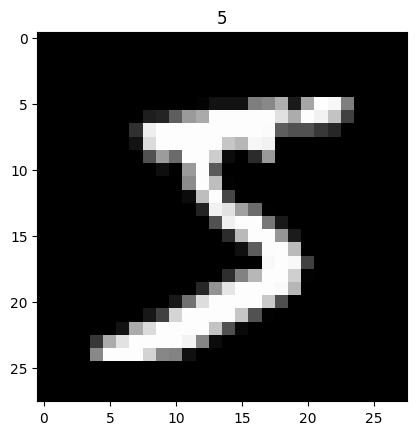

In [6]:
#Plot one train_data
img, target = train_data[0]
print('Size:', img.size(), 'Label:', target)
plt.imshow(img.reshape((28,28)), cmap='gray') # to fix the TypeError: Invalid shape (1, 28, 28) for image data
plt.title('%i' % target)
plt.show()

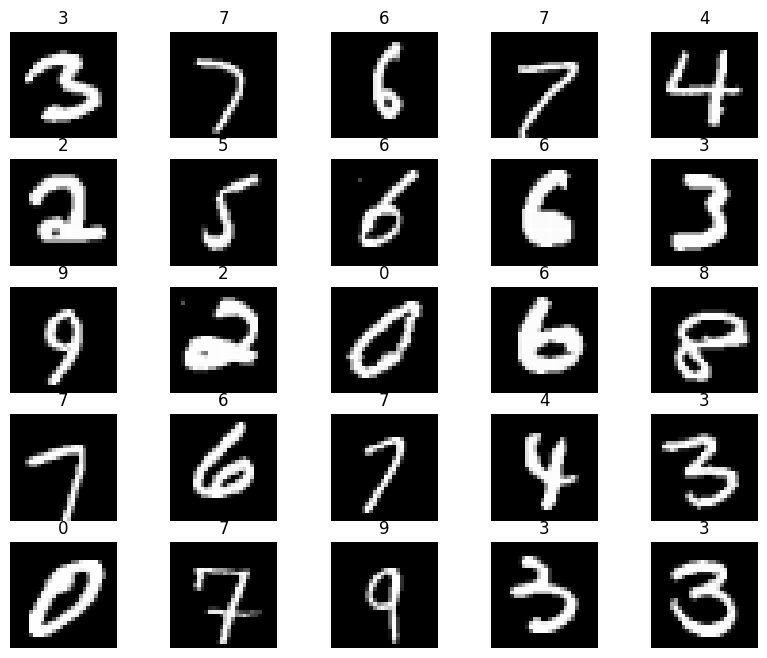

In [7]:
# Plot multiple train_data
def show_imgs(X):
    figure = plt.figure(figsize=(10, 8))
    cols, rows = 5, 5
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(X), size=(1,)).item()
        img, label = X[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()
    
show_imgs(train_data)

## Preparing data for training

In [8]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

# One-layer network and weight visualisation
## Building the Network

- The code is straightforward. In Pytorch there isn't any implementation for the input layer, the input is passed directly into the first hidden layer. However, you'll find the InputLayer in the Keras implementation.

- The number of neurons in the hidden layers and the number of hidden layers is a parameter that can be played with, to get a better result.

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.fc1(x)

model = Net()
# ... this model uses the crossentropy loss
criterion = nn.CrossEntropyLoss()
# and the RMSprop as optimizer 
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)


In [10]:
from torchsummary import summary

# ... print model infomration with summary() method
summary(model, (28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 10]                  7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 10]                  7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03

## Training and evaluating the Model

Our model is now ready to be trained. Let's define functions to train() and validate() the model.

In [11]:
def train(epoch, model, data_loader, log_interval=200):
    
    # ... Set model to training mode
    model.train()
    total_train_loss = 0
    total_correct = 0

    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(tqdm(data_loader, desc=f"Training Epoch {epoch}")):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # ...  Reset the gradient buffers to zero     
        optimizer.zero_grad()
        output = model(data)
        
        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        # Updates the gradients buffer on each parameter
        loss.backward()
        
        # Update weights
        # Applies the calcualted gradients to each parameter
        # based on the selected optimizer and its configuration.
        optimizer.step()
        
        total_train_loss += loss.item()
        
        # The maximum value of dimension 1 (class dimension)
        # is the predicted class. Only the class index is
        # relevant, hence the first return value is ignored.
        # as: values, indices = torch.max(output, dim=1)
        _, pred = torch.max(output, dim=1)
        
        # pred == target gives a boolean tensor, where each
        # element represents whether it was correctly predicted.
        # Taking the sum gives the number of correct predictions
        # for this particular batch.
        total_correct += torch.sum(pred == target).item()
                  
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data.item()))
    
    
    # Divided by len(data_loader.dataset) because it's the number
    # of correct predictions in total.
    accuracy_train = total_correct / len(data_loader.dataset)

    # Divided by len(data_loader) because it is the sum across
    # all batches, therefore it's divided by the number of batches.
    # There is a difference in the length of the data_loader compared
    # to the underlying dataset, which the data_loader partitions into
    # batches:
    #   - len(data_loader) == number of batches the dataloader can create
    #   - len(data_loader.dataset) == number of samples in the dataset
    total_train_loss = total_train_loss / len(data_loader)

    return {
        "loss": total_train_loss,
        "accuracy": accuracy_train,
    }

In [12]:
# torch.inference_mode() disables certain features that are not required
# for inference, such as autograd and other tracking.
# It's optional, but improves performance.
# Alternative: @torch.no_grad(), which only disables autograd. 
@torch.inference_mode()

def validate(model, data_loader):
   
    # ...  put the model in eval mode, which disables raining specific behaviour, such as Dropout.
    model.eval()
    val_loss = 0
    total_correct = 0
    total_preds = []
    total_targets = []
    
    for data, target in tqdm(data_loader, desc="Validation"):
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).item()
        
        _, pred = torch.max(output, dim=1)
        total_correct += torch.sum(pred == target).item()
        # Keep the predictions and targets to inspect later on.
        # .detach() decouples it from the computational graph
        # and .cpu() ensures it's on the CPU, since it shouldn't
        # occupy any unnecesary GPU memory.
        total_preds.append(pred.detach().cpu())
        # target isn't tracked in the computational graph
        # (it's a leaf with requires_grad=False), adding the
        # .detach() doesn't do anything, but if in doubt, just add it.
        total_targets.append(target.cpu())

    val_loss /= len(data_loader)
    accuracy = total_correct / len(data_loader.dataset)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        val_loss, total_correct, len(data_loader.dataset), 100 * accuracy))
    
    return {
        "loss": val_loss,
        "accuracy": accuracy,
        "predictions": torch.cat(total_preds),
        "targets": torch.cat(total_targets),
    }

Now we are ready to train our model using the train() function. An epoch means one pass through the whole training data. After each epoch, we evaluate the model using validate().

In [13]:
%%time

epochs = 5

# Keep track of stats to plot them
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

model.to(device)

for epoch in range(1, epochs + 1):
    train_result = train(epoch, model, train_loader)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])
    
    val_result = validate(model, test_loader)
    val_losses.append(val_result["loss"])
    val_accuracies.append(val_result["accuracy"])

Training Epoch 1:   0%|          | 1/469 [00:00<00:58,  8.04it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.370533


Training Epoch 1:  47%|████▋     | 222/469 [00:01<00:01, 141.72it/s]

Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.433333


Training Epoch 1:  92%|█████████▏| 430/469 [00:03<00:00, 168.98it/s]

Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.291355


Validation: 100%|██████████| 79/79 [00:00<00:00, 186.88it/s]



Validation set: Average loss: 0.3342, Accuracy: 9111/10000 (91.11%)



Training Epoch 2:   3%|▎         | 16/469 [00:00<00:02, 153.90it/s]

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.275712


Training Epoch 2:  50%|████▉     | 234/469 [00:01<00:01, 174.10it/s]

Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.349268


Training Epoch 2:  91%|█████████▏| 428/469 [00:02<00:00, 169.67it/s]

Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.278929


Validation: 100%|██████████| 79/79 [00:00<00:00, 199.60it/s]



Validation set: Average loss: 0.2956, Accuracy: 9163/10000 (91.63%)



Training Epoch 3:   3%|▎         | 15/469 [00:00<00:03, 149.64it/s]

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.368570


Training Epoch 3:  50%|████▉     | 234/469 [00:01<00:01, 180.26it/s]

Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.292669


Training Epoch 3:  93%|█████████▎| 436/469 [00:02<00:00, 175.05it/s]

Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.396413


Validation: 100%|██████████| 79/79 [00:00<00:00, 203.76it/s]



Validation set: Average loss: 0.2808, Accuracy: 9209/10000 (92.09%)



Training Epoch 4:   4%|▎         | 17/469 [00:00<00:02, 163.77it/s]

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.267740


Training Epoch 4:  48%|████▊     | 223/469 [00:01<00:01, 183.28it/s]

Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.365290


Training Epoch 4:  92%|█████████▏| 431/469 [00:02<00:00, 183.39it/s]

Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.242881


Validation: 100%|██████████| 79/79 [00:00<00:00, 205.79it/s]



Validation set: Average loss: 0.2759, Accuracy: 9223/10000 (92.23%)



Training Epoch 5:   4%|▎         | 17/469 [00:00<00:02, 161.17it/s]

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.170441


Training Epoch 5:  47%|████▋     | 220/469 [00:01<00:01, 185.71it/s]

Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.346999


Training Epoch 5:  91%|█████████ | 427/469 [00:02<00:00, 171.42it/s]

Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.244953


Validation: 100%|██████████| 79/79 [00:00<00:00, 203.71it/s]


Validation set: Average loss: 0.2719, Accuracy: 9231/10000 (92.31%)

CPU times: user 15.3 s, sys: 2.11 s, total: 17.4 s
Wall time: 16.4 s


## Loss and Accuracy evaluation during training

Let's now visualize how the training progressed.

Loss is a function of the difference of the network output and the target values. We are minimizing the loss function during training so it should decrease over time.
Accuracy is the classification accuracy for the test data.

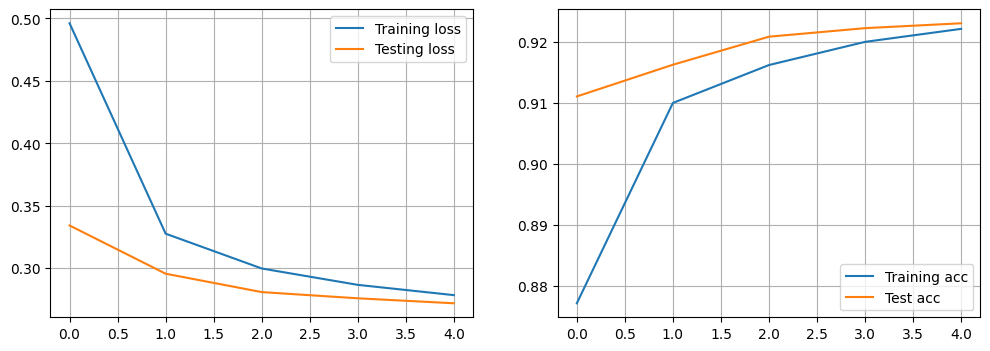

In [14]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Testing loss')
ax1.legend()
ax1.grid()

ax2.plot(train_accuracies, label='Training acc')
ax2.plot(val_accuracies, label='Test acc')
ax2.legend()
ax2.grid()

### Confusion matrix


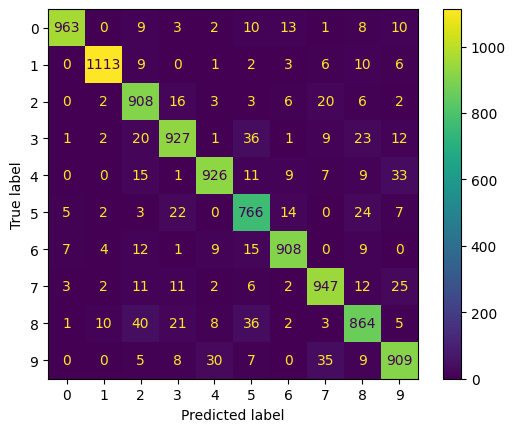

In [15]:
# val_result is from the validation of the last epoch above.
# But you could run it specifically with:
#
# val_result = validate(model, test_loader)

cm = confusion_matrix(val_result["predictions"], val_result["targets"])

disp = ConfusionMatrixDisplay(cm)
disp.plot()

### Plot the weights
The weights connected to a given neuron, when using a one-layer network, have the same shape as the input. They can therefore be plot. To do so we need to re-scale the weight values into 0-255 pixel values.

Weight of classification layer has size: torch.Size([10, 784])


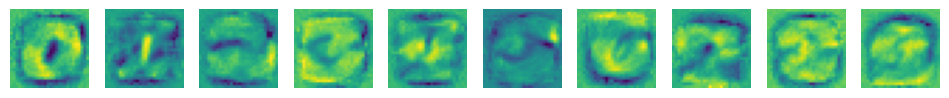

In [16]:
# The weight of the classification layer
classifier_weight = model.fc1.weight.detach().cpu()

print(f"Weight of classification layer has size: {classifier_weight.size()}")

fig = plt.figure(figsize=(12,12))
# Plot the weight as an image for each class
# because the size is: [num_classes x num_inputs],
# it can be iterated over the first dimension to
# get the weight for each individual class.

for i, weight in enumerate(classifier_weight):
    ax = fig.add_subplot(1, 10, 1+i)
    # now put back the pixel values to 0-255 doing a min-max norm and multiplying by 255
    min_value = weight.min()
    max_value = weight.max()
    im = ((weight - min_value) / (max_value - min_value) * 255).numpy()
    ax.axis('off')
    ax.imshow(im.reshape(28, 28))